In [42]:
import pickle
import h2o
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from fancyimpute import MICE as MICE
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.metrics import accuracy_score


%matplotlib inline

In [2]:
h2o.init(max_mem_size = "2G")             #specify max number of bytes. uses all cores by default.
h2o.remove_all()                          #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,15 mins 01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_songlin_p7h00v
H2O cluster total nodes:,1
H2O cluster free memory:,2.506 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [3]:
# This cell is just about making things look nice

# Make plots bigger by default.
# Has to occur after the %matplotlib inline in a different cell. Known issue
plt.rc('figure', figsize=(16.0, 10.0))
plt.rcParams.update({'font.size': 22})

# Make numpy outputs easier to read
np.set_printoptions(precision=3, formatter={'float': '{: 8.3f}'.format})

## Import training data

In [4]:
with open('./data/processed/X_train.pkl', 'rb') as picklefile:
    X_train = pickle.load(picklefile)

In [5]:
with open('./data/processed/y_train.pkl', 'rb') as picklefile:
    y_train = pickle.load(picklefile)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149300 entries, 0 to 149299
Data columns (total 19 columns):
id                         149300 non-null object
date_account_created       149300 non-null datetime64[ns]
timestamp_first_active     149300 non-null datetime64[ns]
date_first_booking         62067 non-null datetime64[ns]
gender                     149300 non-null object
age                        87687 non-null float64
signup_method              149300 non-null object
signup_flow                149300 non-null int64
language                   149300 non-null object
affiliate_channel          149300 non-null object
affiliate_provider         149300 non-null object
first_affiliate_tracked    145093 non-null object
signup_app                 149300 non-null object
first_device_type          149300 non-null object
first_browser              149300 non-null object
splitseed                  149300 non-null float64
account_age                149300 non-null int64
active_age       

In [7]:
X_train.set_index('id', inplace=True)

In [8]:
X_train.head()

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,splitseed,account_age,active_age,booking_age
id,,,,,,,,,,,,,,,,,,
1ok8je1zsw,2010-03-25,2010-03-25,NaT,FEMALE,45.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,0.227831,483,483,0
4wxqtytl2t,2010-05-08,2010-05-08,NaT,-unknown-,NaN,basic,3,en,direct,direct,None,Web,Other/Unknown,-unknown-,0.593557,485,485,0
la3wo57cq4,2010-04-08,2010-04-08,NaT,-unknown-,NaN,basic,2,en,direct,direct,omg,Web,Mac Desktop,Safari,0.563787,484,484,0
97oxlyiw48,2010-03-26,2010-03-26,2010-03-26,-unknown-,NaN,basic,3,en,other,craigslist,None,Web,Other/Unknown,-unknown-,0.364527,483,483,483
36m2hgioax,2010-03-26,2010-03-26,NaT,-unknown-,42.0,basic,2,en,direct,direct,untracked,Web,Mac Desktop,Safari,0.572908,483,483,0


## Deal with wrong values and missing values

In [9]:
# Impute wrong age values (<5 or >100) as avg age
X_age_notnull = X_train[X_train['age'].notnull() & ((X_train['age'] > 5) & (X_train['age'] < 100))]
print (X_age_notnull.shape[0])

X_age_null = X_train[X_train['age'].isna() | (X_train['age'] <= 5) | (X_train['age'] >= 100)]
print (X_age_null.shape[0])

#mean_age = np.mean(X_age_notnull[(X_age_notnull['age']>5) & (X_age_notnull['age']<100)]['age'])
# X_train.loc[(X_train['age']<5) | (X_train['age']>100), 'age'] = mean_age
#X_age_notnull.loc[(X_age_notnull['age']<5) | (X_age_notnull['age']>100), 'age'] = mean_age

85988
63312


In [10]:
# Get rid of the None values in "first_affiliate_tracked"
# X_train.loc[X_train['first_affiliate_tracked'] == 'None', 'first_affiliate_tracked'] = 'missing'

In [11]:
# Drop the irrelevant columns
cols_to_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'splitseed']
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_age_notnull.drop(cols_to_drop, axis=1, inplace=True)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Predict missing age values

In [21]:
y_age = pd.DataFrame(X_age_notnull['age'], columns=['age'])
X_age = deepcopy(X_age_notnull)
X_age.drop('age', axis=1, inplace=True)

In [28]:
df_age = pd.concat([X_age, y_age], axis=1)

In [29]:
h2o_age = h2o.H2OFrame(df_age)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
cols_to_scale = ['account_age', 'active_age', 'booking_age']

In [16]:
ss = StandardScaler()
ss.fit(X_age_train[cols_to_scale])
X_age_train[cols_to_scale] = ss.transform(X_age_train[cols_to_scale])
X_age_test[cols_to_scale] = ss.transform(X_age_test[cols_to_scale])

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [17]:
X_age_train.head()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_age,active_age,booking_age
id,,,,,,,,,,,,,
es7wcw89yw,FEMALE,facebook,12,en,api,other,untracked,iOS,iPhone,-unknown-,0.129825,0.130897,-1.094828
ag1rfe828q,-unknown-,basic,12,en,api,other,untracked,Moweb,iPhone,Mobile Safari,-0.638327,-0.636493,0.881322
ff9e92ujeg,MALE,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,0.225844,0.226821,-1.094828
ux6852ieo1,FEMALE,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,0.897978,0.898287,0.946554
xs1ee7mfnz,FEMALE,facebook,12,en,api,other,untracked,iOS,iPhone,-unknown-,-0.446289,-0.444645,-1.094828


**Apply h2o model**

In [31]:
train, valid, test = h2o_age.split_frame([0.6, 0.2], seed=1234)
X = h2o_age.col_names[:-1]
y = h2o_age.col_names[-1]

In [70]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_age_v1",
    ntrees=100,
    score_each_iteration=True,
    seed=1000000)

In [71]:
rf_v1.train(X, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [72]:
rf_v1.mse

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_age_v1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 131.49837568356563
RMSE: 11.467274117398853
MAE: 8.66645451333474
RMSLE: 0.28406963441201893
Mean Residual Deviance: 131.49837568356563

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 131.31067309930688
RMSE: 11.459086922582745
MAE: 8.634174038597829
RMSLE: 0.281994330699509
Mean Residual Deviance: 131.31067309930688
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-07-31 14:20:02,0.110 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-07-31 14:20:03,0.315 sec,1.0,13.1143978,9.7468949,171.9874287,13.1980295,9.8167761,174.1879817
,2018-07-31 14:20:03,0.435 sec,2.0,12.8623500,9.5592854,165.4400468,12.3013445,9.2226278,151.3230759
,2018-07-31 14:20:03,0.585 sec,3.0,12.7238511,9.4859758,161.8963856,12.0360978,9.0431082,144.8676504
,2018-07-31 14:20:03,0.769 sec,4.0,12.5975039,9.3965733,158.6971056,11.8770965,8.9224479,141.0654216
---,---,---,---,---,---,---,---,---,---
,2018-07-31 14:20:48,45.922 sec,96.0,11.4714156,8.6702204,131.5933757,11.4599949,8.6350152,131.3314827
,2018-07-31 14:20:49,46.770 sec,97.0,11.4702117,8.6689986,131.5657555,11.4599090,8.6345980,131.3295144
,2018-07-31 14:20:50,47.627 sec,98.0,11.4697108,8.6683139,131.5542665,11.4590249,8.6336155,131.3092511
,2018-07-31 14:20:51,48.720 sec,99.0,11.4684776,8.6678801,131.5259794,11.4587449,8.6335193,131.3028337



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
first_browser,28141214.0000000,1.0,0.1437796
account_age,26650816.0000000,0.9470386,0.1361648
active_age,26072128.0000000,0.9264749,0.1332082
booking_age,19017594.0000000,0.6757915,0.0971650
first_affiliate_tracked,16732598.0000000,0.5945940,0.0854905
affiliate_channel,16266286.0000000,0.5780236,0.0831080
gender,14409912.0000000,0.5120572,0.0736234
affiliate_provider,12093409.0000000,0.4297401,0.0617879
first_device_type,10922462.0000000,0.3881304,0.0558052
language,8868237.0,0.3151334,0.0453098


<bound method ModelBase.mse of >

## Predict with random Forest

In [73]:
y_age = pd.DataFrame(X_age_notnull['age'], columns=['age'])
X_age = deepcopy(X_age_notnull)
X_age.drop('age', axis=1, inplace=True)

NameError: name 'X_age_train' is not defined

In [74]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age, train_size=0.25)

In [219]:
X_age_train['gender'].value_counts()/np.sum(X_age_train['gender'].value_counts())

FEMALE       0.463041
MALE         0.403638
-unknown-    0.131693
OTHER        0.001628
Name: gender, dtype: float64

In [241]:
X_age_train.select_dtypes(exclude='object')

,signup_flow,account_age,active_age,booking_age
id,,,,
gpq104mqcm,3,513,513,0
xauhnhzxe6,0,532,532,0
urxrrd09a6,0,523,523,523
ozb500dz1n,0,506,506,0
gw1mnk9hfx,25,531,531,0
k1fd7tsbn8,0,533,533,533
h7mdnzaqnv,0,531,531,0
zme6qd8aic,0,522,522,522
rswr8fofeb,0,533,533,533


In [259]:
def custom_dummify(df, threshold):
    df_concat_
    df_noncat = df.select_dtypes(exclude='object')
    print(df_noncat.shape)
    df = df.select_dtypes(include='object')
    for column in range(len(df.columns)):
        col_name = df.columns[column]
        levels = df.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_cols = []
        for level_values in levels.index:
            if (levels[level_values]/count_all < threshold):
                pass
            else:
                significant_cols.append(level_values)
        df_dummy = pd.get_dummies(df[col_name], prefix=col_name)
        cols_to_keep = [(col_name+"_"+x) for x in significant_cols]
        df_dummy_kept = pd.DataFrame(df_dummy[cols_to_keep], columns=cols_to_keep)
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_unify = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df = pd.concat([df, df_unify], axis=1)
    print(df.shape)
    return pd.concat([df_noncat, df], axis=1 )

In [260]:
custom_dummify(X_age_train, 0.01)

(0, 0)
(0, 0)


""


In [220]:
col_dict = {}
for column in range(len(X_age_train.columns)):
    if (X_age_train.dtypes[column] == 'object'):
        col_name = X_age_train.columns[column]
        levels = X_age_train.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_values = []
        for level_values in levels.index:
            if (levels[level_values]/count_all < .01):
                pass
                # value_dict[level_values] = 'catch_all'
            else:
                significant_values.append(level_values)
        col_dict[col_name] = significant_values

In [221]:
for column in range(len(X_age_train.columns)):
    if (X_age_train.dtypes[column] == 'object'):
        col_name = X_age_train.columns[column]
        print(col_name, col_dict[col_name])

gender ['FEMALE', 'MALE', '-unknown-']
signup_method ['basic', 'facebook']
language ['en']
affiliate_channel ['direct', 'sem-brand', 'sem-non-brand', 'api', 'other', 'seo', 'content']
affiliate_provider ['direct', 'google', 'other', 'craigslist', 'facebook']
first_affiliate_tracked ['untracked', 'linked', 'omg', 'tracked-other']
signup_app ['Web', 'iOS', 'Android', 'Moweb']
first_device_type ['Mac Desktop', 'Windows Desktop', 'iPhone', 'iPad', 'Other/Unknown', 'Android Phone']
first_browser ['Chrome', 'Safari', 'Firefox', '-unknown-', 'IE', 'Mobile Safari']


In [236]:
df = pd.DataFrame()
for column in range(len(X_age_train.columns)):
    if (X_age_train.dtypes[column] == 'object'):
        col_name = X_age_train.columns[column]
        df_dummy = X_age_train[col_name]
        df_dummy = pd.get_dummies(df_dummy, prefix=col_name)
        cols_to_keep = col_dict[col_name]
        cols_to_keep = [(col_name+"_"+x) for x in cols_to_keep]
        df_dummy_kept = df_dummy[cols_to_keep]
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_addition = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df = pd.concat([df, df_addition], axis=1)

In [230]:
df_dummy = pd.get_dummies(X_age_train['gender'], prefix='gender')

In [238]:
df.shape

(21497, 47)

In [170]:
cols_to_keep = list(categories.values())
cols_to_keep

['-unknown-', 'MALE', 'FEMALE']

In [154]:
X_age_train['gender'].value_counts()

FEMALE       9954
MALE         8677
-unknown-    2831
OTHER          35
Name: gender, dtype: int64

In [141]:
col_dict['affiliate_provider']

{'baidu': 'affiliate_provider[others]',
 'bing': 'affiliate_provider[others]',
 'craigslist': 'craigslist',
 'direct': 'direct',
 'email-marketing': 'affiliate_provider[others]',
 'facebook': 'facebook',
 'facebook-open-graph': 'affiliate_provider[others]',
 'google': 'google',
 'gsp': 'affiliate_provider[others]',
 'meetup': 'affiliate_provider[others]',
 'naver': 'affiliate_provider[others]',
 'other': 'other',
 'padmapper': 'affiliate_provider[others]',
 'vast': 'affiliate_provider[others]',
 'yahoo': 'affiliate_provider[others]',
 'yandex': 'affiliate_provider[others]'}

In [239]:
X_age_train = pd.get_dummies(X_age_train)

In [259]:
RF=RandomForestRegressor()

In [275]:
np.linspace(50, 100, 10).astype('int')

array([ 50,  55,  61,  66,  72,  77,  83,  88,  94, 100])

In [279]:
param_grid = [{
        'max_depth': np.linspace(1, 100, 5).astype('int'),
        'n_estimators': np.linspace(50, 100, 5).astype('int')
    }]

In [280]:
grid = GridSearchCV(RF, cv=5, n_jobs=-1, param_grid=param_grid)

In [281]:
grid.fit(X_age_train, y_age_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': array([ 50,  62,  75,  87, 100]), 'max_depth': array([  1,  25,  50,  75, 100])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [285]:
with open('./data/model/age_prediction.pkl', 'wb') as picklefile:
    pickle.dump(grid, picklefile)

## Check model performance on test data

In [286]:
X_age_test = pd.get_dummies(X_age_test)

In [289]:
X_age_test.shape

(21922, 109)

In [290]:
X_age_train.shape

(65765, 118)

In [309]:
from sklearn.preprocessing import LabelEncoder

In [311]:
le = LabelEncoder()
train_transformed = le.fit_transform(y_age_train)

array([46, 21, 25, 67, 16])

In [ ]:
grid.score()

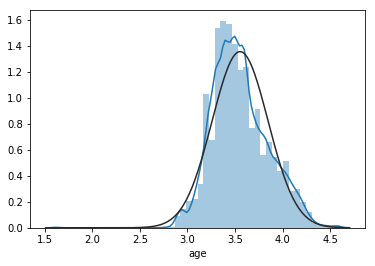

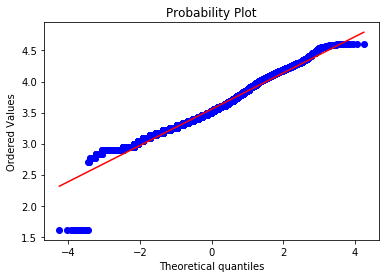

In [247]:
from scipy.stats import norm
from scipy import stats
import seaborn as sns
sns.distplot(np.log(y_age_train),fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(y_age_train), plot=plt)

In [200]:
X_age_train.head()

,date_account_created,timestamp_first_active,date_first_booking,signup_flow,splitseed,account_age,active_age,booking_age,gender_-unknown-,gender_FEMALE,...,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
id,,,,,,,,,,,,,,,,,,,,,
x6ev29z09e,2012-04-24,2012-04-24,NaT,1,0.486485,-1.308089,-1.305143,-1.095201,0,1,...,0,0,0,0,0,0,0,0,0,0
a73pqeixiz,2013-12-09,2013-12-09,2013-12-12,12,0.333952,0.607674,0.608144,0.930655,0,0,...,0,0,0,0,0,0,0,0,0,0
wkmltvgbok,2013-05-21,2013-05-21,2013-05-25,0,0.430894,-0.062843,-0.061507,0.903797,0,1,...,0,1,0,0,0,0,0,0,0,0
v2m36mhsbr,2012-12-16,2012-12-16,2013-02-21,0,0.345105,-0.541784,-0.539828,0.892286,0,0,...,0,0,0,0,0,0,0,0,0,0
lk4t5zhbet,2014-04-15,2014-04-15,NaT,0,0.320236,0.990827,0.990801,-1.095201,1,0,...,0,0,0,0,0,0,0,0,0,0
